In [1]:
import pandas as pd
import joypy
from evaluation_utils import read_processed_shards, unpivot_bvaseline_model, unpivot_ssl_model, to_latex_table
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
import pylab as pl
import matplotlib as mpl
from collections import OrderedDict
import itertools
from constants import MODE_4_PROCESSED_DIR, SSL_MODELS, TRAINING_SCHEMES, BASELINES, ENCODERS, TEST_METRIC, GENERATION_ALL, AUXILIARY_ALL, HYBRID_ALL, CONTRAST_ALL, model_abbreviations
import joypy
from plots import plot_training_scheme_histograms
%matplotlib inline

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Read the data

In [2]:
raw_results = read_processed_shards(MODE_4_PROCESSED_DIR) # mode1
raw_results.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
raw_results.dropna(axis=0, inplace=True)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


In [3]:
df_ssl = unpivot_ssl_model(raw_results, TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_bvaseline_model(raw_results, TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

# Training scheme results

/home/daen/.conda/envs/scara/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/daen/Thesis/graphworld/evaluation/plots.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


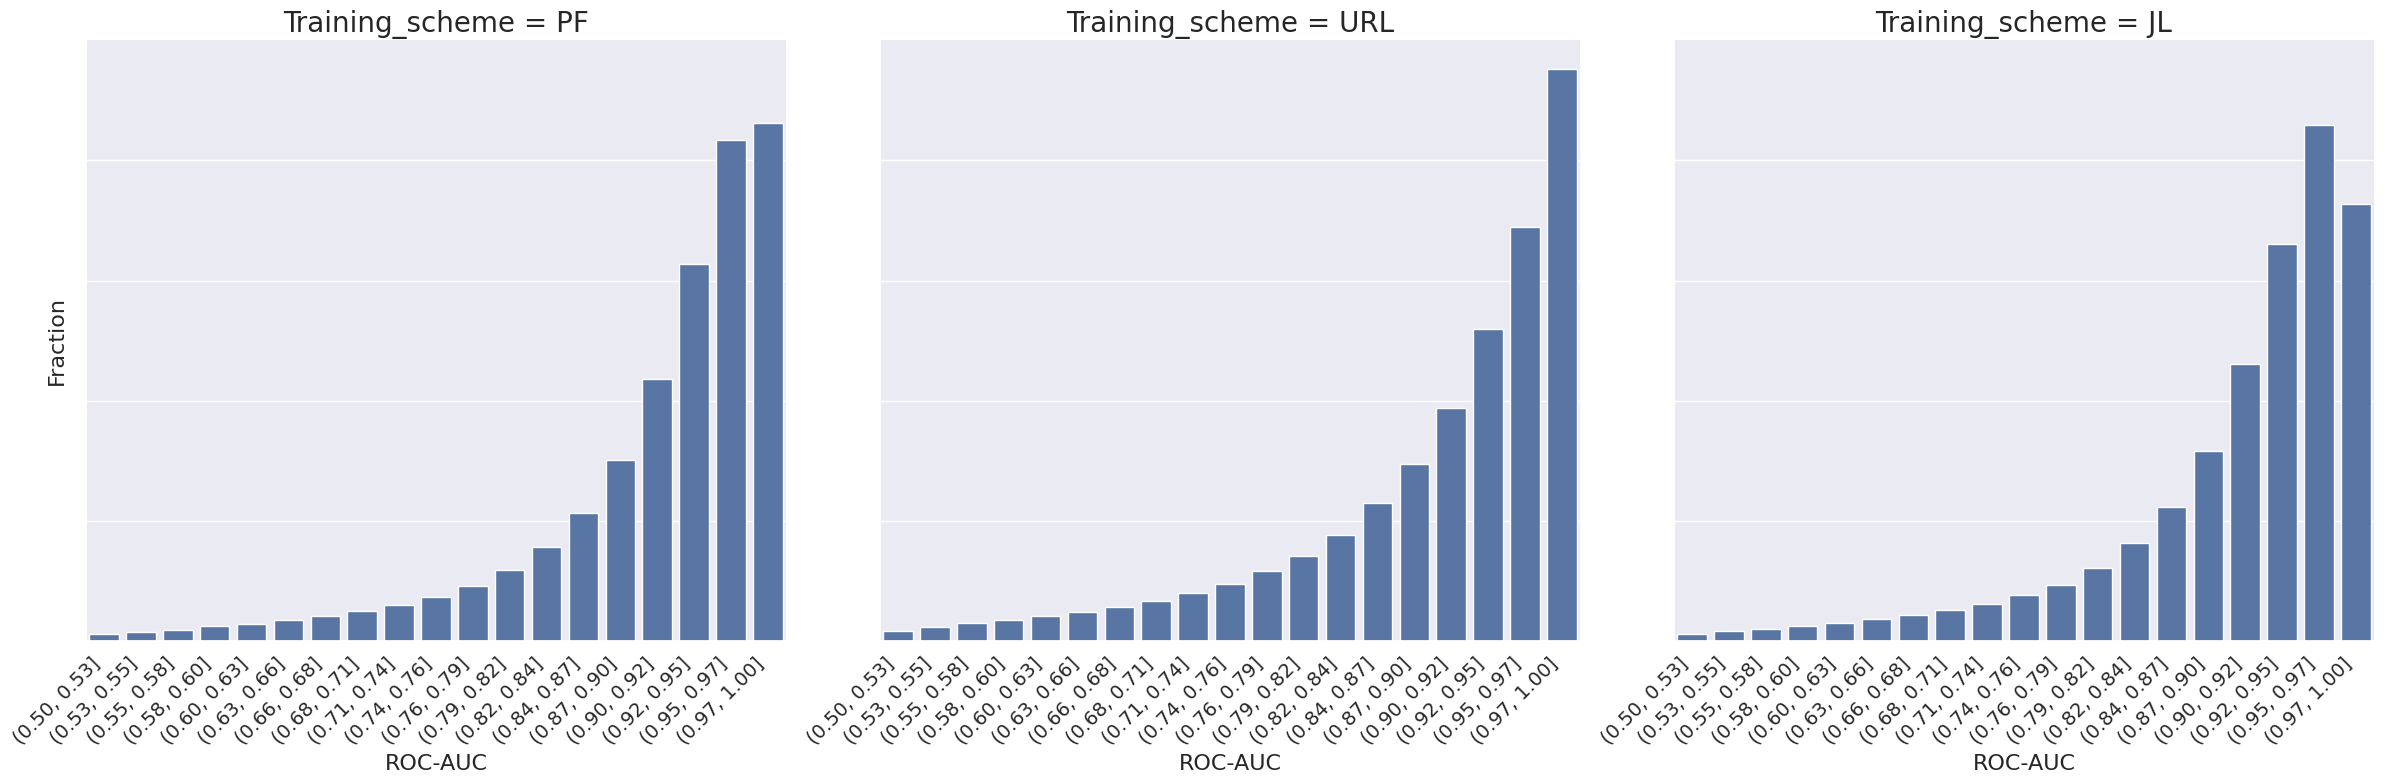

In [4]:
plot_training_scheme_histograms(df_ssl)

# Results per model

We here investigate the global results of all models.

In [5]:
df_baseline.groupby('Baseline_model')[TEST_METRIC].mean()
pd.pivot_table(
    df_baseline,
    index='Baseline_model',
    values=TEST_METRIC,
    aggfunc=lambda x: f'{x.mean():.2f}±{x.std():.2f}'
)

,test_rocauc_ovr
Baseline_model,
GAT,0.90±0.09
GCN,0.90±0.09
GIN,0.86±0.11


In [6]:
best_models = pd.pivot_table(
    df_ssl,
    index='SSL_model',
    columns=['Training_scheme', 'Encoder'],
    values='test_rocauc_ovr',
    aggfunc=lambda x: f'{x.mean():.2f}±{x.std():.2f}'
)

In [8]:
generation_df = best_models.loc[GENERATION_ALL]
generation_df

Training_scheme                           JL                               PF  \
Encoder                                  GAT        GCN        GIN        GAT   
SSL_model                                                                       
AttributeMask                      0.90±0.09  0.89±0.10  0.87±0.11  0.91±0.08   
CorruptedEmbeddingsReconstruction  0.91±0.08  0.90±0.09  0.86±0.11  0.91±0.08   
CorruptedFeaturesReconstruction    0.91±0.08  0.90±0.09  0.87±0.10  0.92±0.08   
EdgeMask                           0.91±0.08  0.90±0.09  0.86±0.11  0.91±0.08   
GAE                                0.90±0.10  0.90±0.10  0.86±0.11  0.91±0.09   

Training_scheme                                                URL             \
Encoder                                  GCN        GIN        GAT        GCN   
SSL_model                                                                       
AttributeMask                      0.90±0.08  0.87±0.10  0.89±0.11  0.91±0.11   
CorruptedEmbeddingsReconstruction  0.91±0.09  0.86±0.11  0.87±0.11  0.88±0.10   
CorruptedFeaturesReconstruction    0.91±0.09  0.88±0.10  0.94±0.08  0.92±0.09   
EdgeMask                           0.91±0.09  0.86±0.11  0.87±0.11  0.89±0.10   
GAE                                0.90±0.10  0.86±0.11  0.88±0.12  0.91±0.10   

Training_scheme                               
Encoder                                  GIN  
SSL_model                                     
AttributeMask                      0.87±0.12  
CorruptedEmbeddingsReconstruction  0.79±0.11  
CorruptedFeaturesReconstruction    0.93±0.08  
EdgeMask                           0.81±0.11  
GAE                                0.87±0.11

In [9]:
to_latex_table(generation_df)

\texttt{AttributeMask} & $0.90\pm0.08$ & $0.91\pm0.08$ & $0.87\pm0.10$ & $0.91\pm0.11$ & $0.89\pm0.11$ & $0.87\pm0.12$ & $0.89\pm0.10$ & $0.90\pm0.09$ & $0.87\pm0.11$
\\
\texttt{CorruptedEmbeddingsReconstruction} & $0.91\pm0.09$ & $0.91\pm0.08$ & $0.86\pm0.11$ & $0.88\pm0.10$ & $0.87\pm0.11$ & $0.79\pm0.11$ & $0.90\pm0.09$ & $0.91\pm0.08$ & $0.86\pm0.11$
\\
\texttt{CorruptedFeaturesReconstruction} & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.88\pm0.10$ & $0.92\pm0.09$ & $0.94\pm0.08$ & $0.93\pm0.08$ & $0.90\pm0.09$ & $0.91\pm0.08$ & $0.87\pm0.10$
\\
\texttt{EdgeMask} & $0.91\pm0.09$ & $0.91\pm0.08$ & $0.86\pm0.11$ & $0.89\pm0.10$ & $0.87\pm0.11$ & $0.81\pm0.11$ & $0.90\pm0.09$ & $0.91\pm0.08$ & $0.86\pm0.11$
\\
\texttt{GAE} & $0.90\pm0.10$ & $0.91\pm0.09$ & $0.86\pm0.11$ & $0.91\pm0.10$ & $0.88\pm0.12$ & $0.87\pm0.11$ & $0.90\pm0.10$ & $0.90\pm0.10$ & $0.86\pm0.11$
\\


In [10]:
auxiliary_df = best_models.loc[AUXILIARY_ALL]  
auxiliary_df

Training_scheme                     JL                               PF  \
Encoder                            GAT        GCN        GIN        GAT   
SSL_model                                                                 
NodeClusteringWithAlignment  0.94±0.07  0.92±0.08  0.92±0.09  0.95±0.07   
S2GRL                        0.91±0.08  0.91±0.09  0.87±0.10  0.91±0.09   
PairwiseAttrSim              0.91±0.08  0.90±0.09  0.87±0.11  0.92±0.08   
GraphPartitioning            0.91±0.09  0.91±0.09  0.87±0.11  0.92±0.08   

Training_scheme                                          URL             \
Encoder                            GCN        GIN        GAT        GCN   
SSL_model                                                                 
NodeClusteringWithAlignment  0.93±0.09  0.91±0.10  0.95±0.08  0.94±0.09   
S2GRL                        0.91±0.09  0.87±0.10  0.89±0.10  0.91±0.09   
PairwiseAttrSim              0.91±0.09  0.88±0.11  0.91±0.09  0.89±0.10   
GraphPartitioning            0.91±0.09  0.87±0.10  0.91±0.10  0.91±0.10   

Training_scheme                         
Encoder                            GIN  
SSL_model                               
NodeClusteringWithAlignment  0.94±0.09  
S2GRL                        0.86±0.10  
PairwiseAttrSim              0.86±0.11  
GraphPartitioning            0.86±0.12

In [11]:
to_latex_table(auxiliary_df)

\texttt{NodeClusteringWithAlignment} & $0.93\pm0.09$ & $0.95\pm0.07$ & $0.91\pm0.10$ & $0.94\pm0.09$ & $0.95\pm0.08$ & $0.94\pm0.09$ & $0.92\pm0.08$ & $0.94\pm0.07$ & $0.92\pm0.09$
\\
\texttt{S2GRL} & $0.91\pm0.09$ & $0.91\pm0.09$ & $0.87\pm0.10$ & $0.91\pm0.09$ & $0.89\pm0.10$ & $0.86\pm0.10$ & $0.91\pm0.09$ & $0.91\pm0.08$ & $0.87\pm0.10$
\\
\texttt{PairwiseAttrSim} & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.88\pm0.11$ & $0.89\pm0.10$ & $0.91\pm0.09$ & $0.86\pm0.11$ & $0.90\pm0.09$ & $0.91\pm0.08$ & $0.87\pm0.11$
\\
\texttt{GraphPartitioning} & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.87\pm0.10$ & $0.91\pm0.10$ & $0.91\pm0.10$ & $0.86\pm0.12$ & $0.91\pm0.09$ & $0.91\pm0.09$ & $0.87\pm0.11$
\\


In [12]:
contrast_df = best_models.loc[CONTRAST_ALL]
contrast_df

Training_scheme          JL                               PF             \
Encoder                 GAT        GCN        GIN        GAT        GCN   
SSL_model                                                                 
BGRL              0.91±0.08  0.90±0.09  0.87±0.10  0.92±0.08  0.91±0.09   
GBT               0.91±0.08  0.91±0.09  0.87±0.10  0.92±0.08  0.91±0.09   
GCA               0.92±0.07  0.91±0.09  0.88±0.10  0.93±0.07  0.92±0.09   
SelfGNNPPR              NaN  0.94±0.07        NaN        NaN  0.94±0.07   
SelfGNNSplit      0.90±0.09  0.90±0.10  0.85±0.11  0.91±0.09  0.91±0.09   
MERIT                   NaN  0.93±0.08        NaN        NaN  0.94±0.07   
DeepGraphInfomax  0.91±0.09  0.90±0.10  0.86±0.11  0.91±0.09  0.90±0.10   
GraphInfoClust    0.92±0.08  0.90±0.09  0.88±0.10  0.92±0.08  0.91±0.09   
SUBGCON           0.89±0.08  0.89±0.08  0.85±0.10  0.90±0.09  0.90±0.08   

Training_scheme                    URL                        
Encoder                 GIN        GAT        GCN        GIN  
SSL_model                                                     
BGRL              0.87±0.10  0.90±0.10  0.91±0.09  0.86±0.11  
GBT               0.87±0.10  0.91±0.09  0.92±0.09  0.87±0.10  
GCA               0.88±0.10  0.94±0.08  0.92±0.09  0.89±0.10  
SelfGNNPPR              NaN        NaN  0.94±0.08        NaN  
SelfGNNSplit      0.86±0.11  0.88±0.11  0.90±0.11  0.84±0.12  
MERIT                   NaN        NaN  0.95±0.07        NaN  
DeepGraphInfomax  0.86±0.11  0.85±0.12  0.86±0.11  0.80±0.12  
GraphInfoClust    0.87±0.10  0.87±0.11  0.88±0.10  0.83±0.11  
SUBGCON           0.85±0.09  0.88±0.09  0.90±0.08  0.85±0.11

In [13]:
to_latex_table(contrast_df)

\texttt{BGRL} & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.87\pm0.10$ & $0.91\pm0.09$ & $0.90\pm0.10$ & $0.86\pm0.11$ & $0.90\pm0.09$ & $0.91\pm0.08$ & $0.87\pm0.10$
\\
\texttt{GBT} & $0.91\pm0.09$ & $0.92\pm0.08$ & $0.87\pm0.10$ & $0.92\pm0.09$ & $0.91\pm0.09$ & $0.87\pm0.10$ & $0.91\pm0.09$ & $0.91\pm0.08$ & $0.87\pm0.10$
\\
\texttt{GCA} & $0.92\pm0.09$ & $0.93\pm0.07$ & $0.88\pm0.10$ & $0.92\pm0.09$ & $0.94\pm0.08$ & $0.89\pm0.10$ & $0.91\pm0.09$ & $0.92\pm0.07$ & $0.88\pm0.10$
\\
\texttt{SelfGNNPPR} & $0.94\pm0.07$ &- &- & $0.94\pm0.08$ &- &- & $0.94\pm0.07$ &- &-
\\
\texttt{SelfGNNSplit} & $0.91\pm0.09$ & $0.91\pm0.09$ & $0.86\pm0.11$ & $0.90\pm0.11$ & $0.88\pm0.11$ & $0.84\pm0.12$ & $0.90\pm0.10$ & $0.90\pm0.09$ & $0.85\pm0.11$
\\
\texttt{MERIT} & $0.94\pm0.07$ &- &- & $0.95\pm0.07$ &- &- & $0.93\pm0.08$ &- &-
\\
\texttt{DeepGraphInfomax} & $0.90\pm0.10$ & $0.91\pm0.09$ & $0.86\pm0.11$ & $0.86\pm0.11$ & $0.85\pm0.12$ & $0.80\pm0.12$ & $0.90\pm0.10$ & $0.91\pm0.09$ & $0.86\pm0.11$
\\
\tex

In [14]:
hybrid_df = best_models.loc[HYBRID_ALL]
hybrid_df

Training_scheme         JL                               PF             \
Encoder                GAT        GCN        GIN        GAT        GCN   
SSL_model                                                                
G_Zoom                 NaN  0.95±0.07        NaN        NaN  0.95±0.07   
MEtAl            0.94±0.07  0.91±0.09  0.91±0.08  0.93±0.07  0.92±0.09   
MVMI_FT          0.95±0.08  0.95±0.07  0.94±0.08  0.95±0.09  0.96±0.08   

Training_scheme                   URL                        
Encoder                GIN        GAT        GCN        GIN  
SSL_model                                                    
G_Zoom                 NaN        NaN  0.96±0.07        NaN  
MEtAl            0.90±0.09  0.94±0.07  0.93±0.08  0.93±0.08  
MVMI_FT          0.94±0.08  0.92±0.10  0.92±0.10  0.94±0.08

In [15]:
to_latex_table(hybrid_df)

\texttt{G_Zoom} & $0.95\pm0.07$ &- &- & $0.96\pm0.07$ &- &- & $0.95\pm0.07$ &- &-
\\
\texttt{MEtAl} & $0.92\pm0.09$ & $0.93\pm0.07$ & $0.90\pm0.09$ & $0.93\pm0.08$ & $0.94\pm0.07$ & $0.93\pm0.08$ & $0.91\pm0.09$ & $0.94\pm0.07$ & $0.91\pm0.08$
\\
\texttt{MVMI_FT} & $0.96\pm0.08$ & $0.95\pm0.09$ & $0.94\pm0.08$ & $0.92\pm0.10$ & $0.92\pm0.10$ & $0.94\pm0.08$ & $0.95\pm0.07$ & $0.95\pm0.08$ & $0.94\pm0.08$
\\


/home/daen/.conda/envs/scara/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


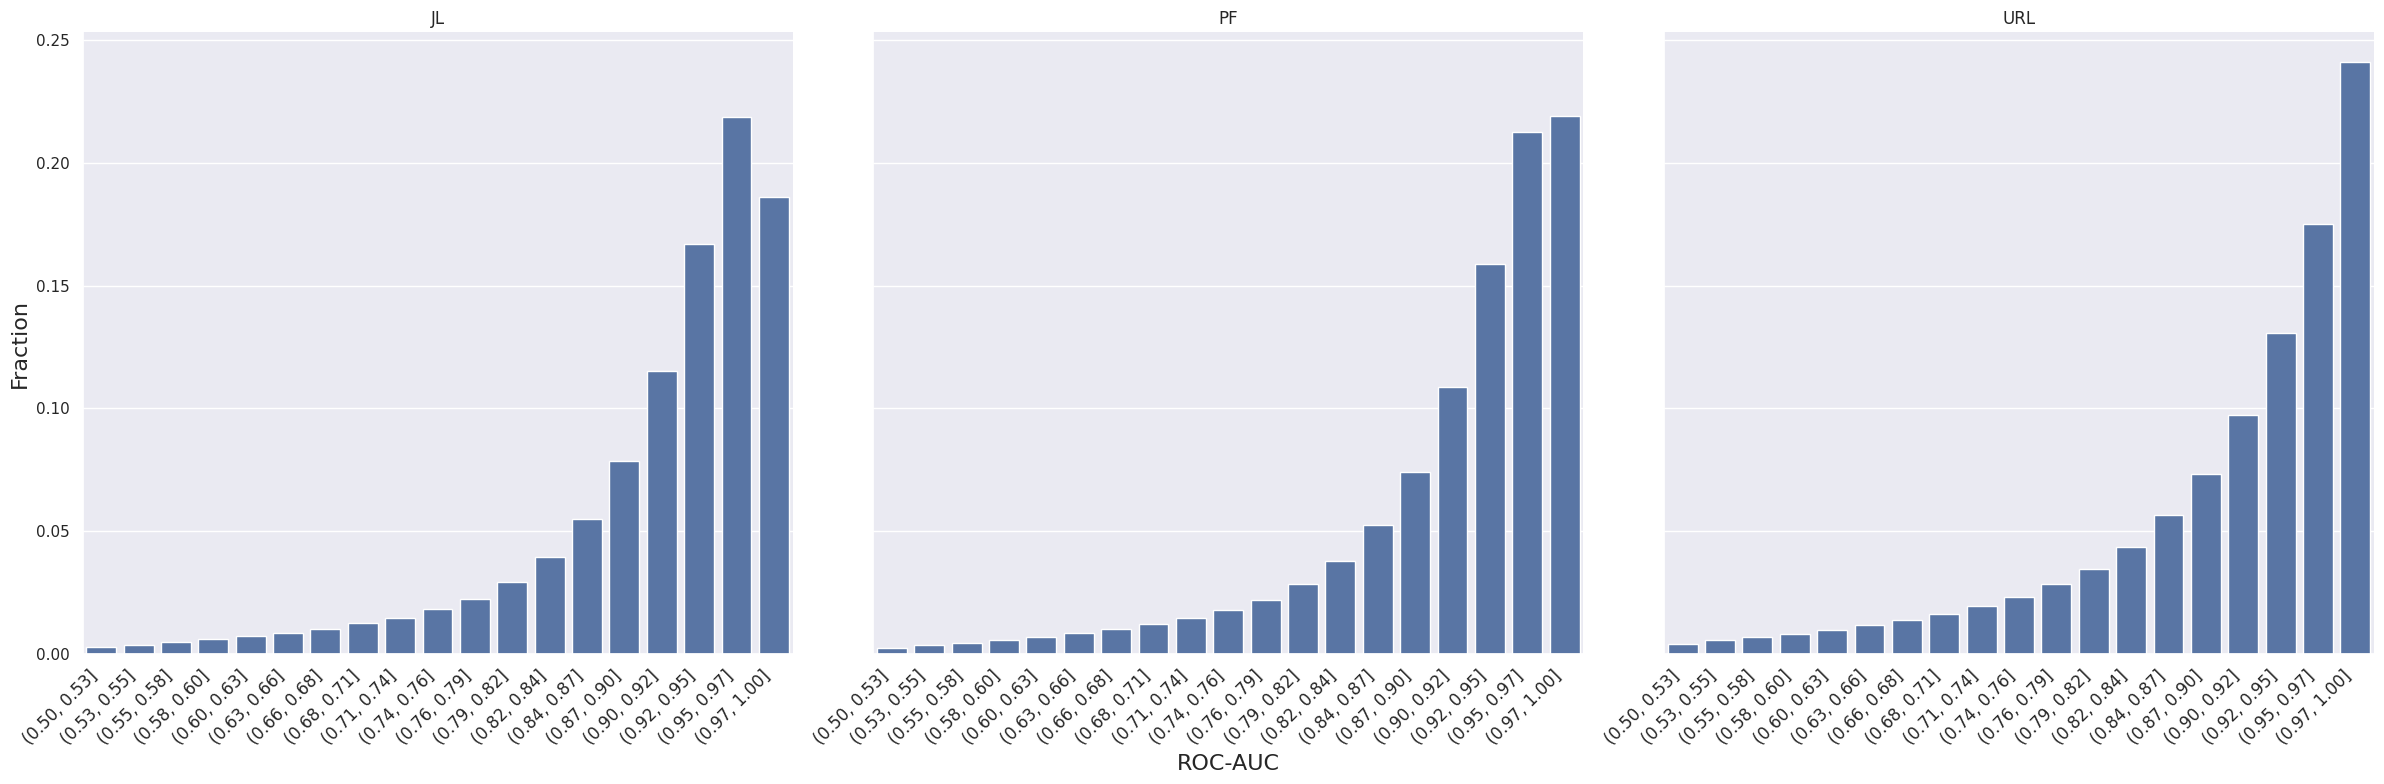

In [21]:
df = df_ssl
grp = df.groupby('Training_scheme')
N_bins = 20
results = []
for ax, (key, v) in zip(g.axes.flat, grp):
    bins = pd.cut(v[TEST_METRIC], bins=np.linspace(1/2, 1, N_bins)).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', 'test_rocauc_ovr': 'Fraction' })
    bins['Fraction'] = bins['Fraction'] / bins['Fraction'].sum()
    bins['Training_scheme'] = key
    bins['ROC-AUC'] = bins['ROC-AUC'].apply(lambda x: f'({x.left:.2f}, {x.right:.2f}]')
    results += [bins]


bin_df = pd.concat(results)
bin_df.head()
g = sns.FacetGrid(data=bin_df, col='Training_scheme', height=8, aspect=1)\
    .map(sns.barplot, 'ROC-AUC', 'Fraction')\
    .set_titles(template='{col_name}', fontsize=500)
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
    ax.set_xlabel('')
    

g.axes.flat[1].set_xlabel('ROC-AUC', fontsize=16)
g.axes.flat[0].set_ylabel('Fraction', fontsize=16)


plt.tight_layout()

### Visualize distribution for each model

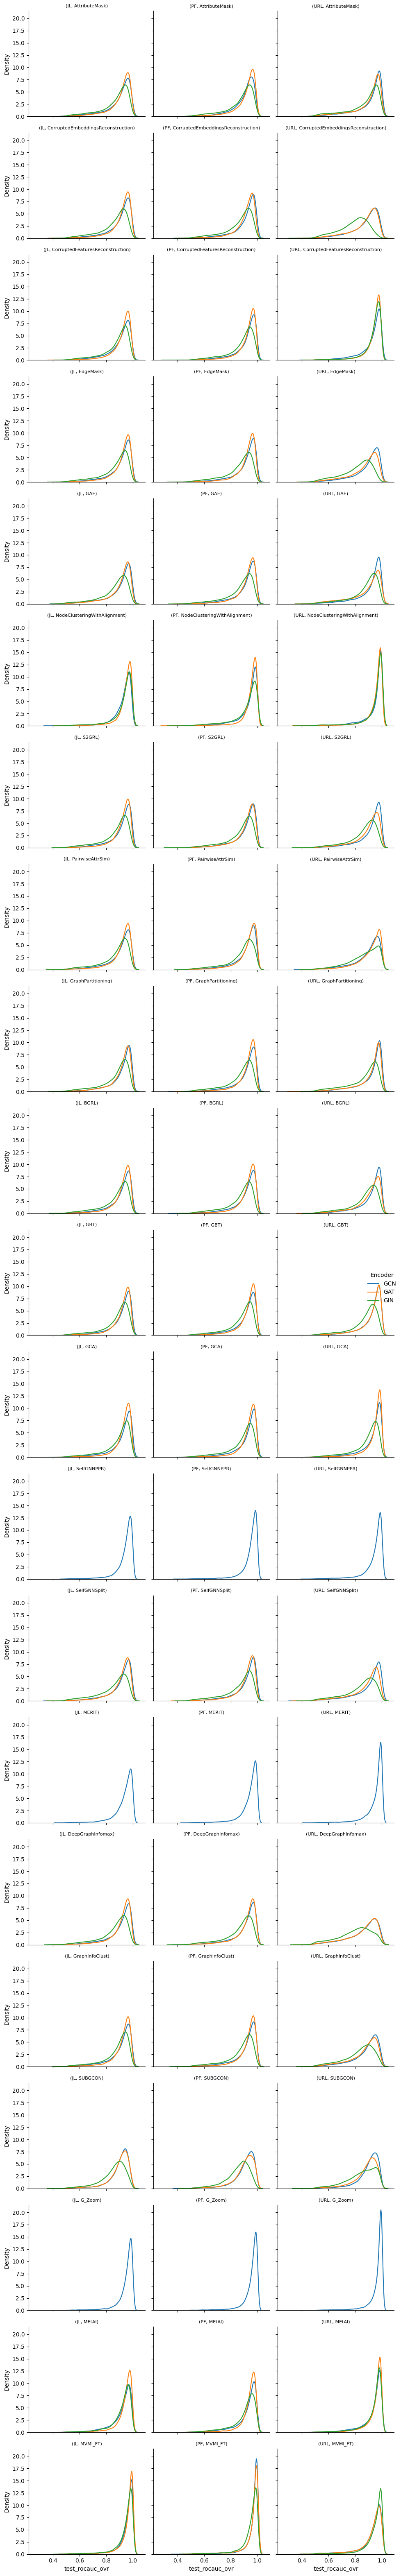

In [ ]:
g = sns.FacetGrid(data=df_ssl, row='SSL_model', col='Training_scheme', hue='Encoder')
g.map(sns.kdeplot, TEST_METRIC)
g.set_titles(template="({col_name}, {row_name})", size=8)
g.add_legend()
plt.tight_layout()

### Joy plotting

In [38]:
df_pivoted = df_ssl[df_ssl.Encoder == 'GCN'].pivot(index=['Graph_ID', 'SSL_model'], columns='Training_scheme', values='test_rocauc_ovr')\
    .reset_index().drop(columns='Graph_ID')

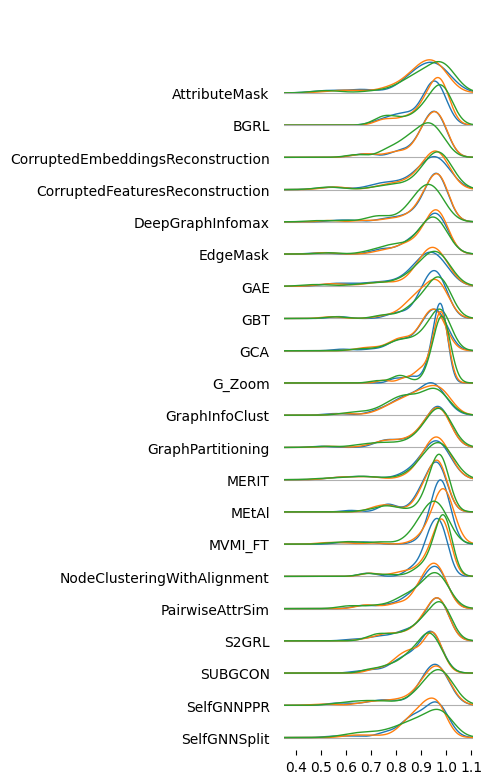

In [49]:
joypy.joyplot(df_pivoted.sample(n=1_000), by='SSL_model', fill=False, figsize=(5, 8),
              grid="y", linewidth=1); pass

In [13]:
fig, axes = joypy.joyplot(.reset_index().drop(columns=['Graph_ID']).sample(n=10_000), 
                          by='SSL_model', fill=False, legend=True, hist=True, bins=20,
                          grid=True); pass

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/daen/.conda/envs/scara/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_28526/1273899357.py", line 1, in <cell line: 1>
    fig, axes = joypy.joyplot(df_pivoted.reset_index().drop(columns=['Graph_ID']).sample(n=10_000),
NameError: name 'df_pivoted' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daen/.conda/envs/scara/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/daen/.conda/envs/scara/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/daen/.conda/envs/scara/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1012, in structure